# Data Preparation Pipeline

## Step 0: Install & Import Libraries
We install and import the necessary Python libraries.
- `pandas`, `numpy`: For handling structured data.
- `matplotlib`: For plotting (if needed for EDA).
- `re`: For regular expressions to clean text.
- `nltk`: The Natural Language Toolkit, used here for sentiment analysis.
- `tqdm`: For progress bars during long operations.
- `SentimentIntensityAnalyzer` (VADER): A pre-trained sentiment analysis tool specifically tuned for social media text.

In [ ]:
!pip install pandas nltk tqdm matplotlib


In [ ]:
import pandas as pd
import numpy as np
import re
import string
from tqdm import tqdm
import matplotlib.pyplot as plt

## Step 1: Load Raw Data
We load the two primary datasets:
1.  `stock_tweets.csv`: The social media data containing raw text tweets.
2.  `stock_yfinance_data.csv`: The financial market data containing price history.

- **Outcome:** Displays the first few rows of each dataframe to confirm successful loading.

In [ ]:
# Adjust file path if using Google Drive or different location
tweet_df = pd.read_csv('/content/stock_tweets.csv')


**Robust Preprocessing** **Function**

## Step 2: Clean Tweet Data
Social media text is noisy. We define a `clean_tweet` function to standardize the text before analysis.
- **Process:**
    - Removes URLs (http links).
    - Removes user mentions (@user) and hashtags (#stock).
    - Removes special characters (like emojis or punctuation).
    - Converts text to lowercase.
- **Outcome:** A new column `cleaned_tweet` containing processing-ready text.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize # New import

# Download necessary NLTK data (if not already downloaded)
# Make sure to run this cell and potentially uncomment the lines below if you haven't downloaded these resources before.
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4') # Open Multilingual Wordnet
nltk.download('punkt_tab') # Download punkt_tab as it's required for word_tokenize

def clean_tweet(tweet):
    # Handle potential non-string inputs gracefully
    if not isinstance(tweet, str):
        return ""
    # Convert to lowercase
    tweet = tweet.lower()
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove hashtags (keeping the text)
    tweet = re.sub(r'#\w+', '', tweet)
    # Remove punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    # Remove extra whitespace
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

def preprocess_text(tweet):
    # Clean the tweet
    cleaned_tweet = clean_tweet(tweet)

    # Tokenization using word_tokenize
    tokens = word_tokenize(cleaned_tweet) # Changed from .split() to word_tokenize

    # Remove Stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [word for word in tokens if isinstance(word, str)] # Ensure elements are strings before lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]


    # Join tokens back into a string
    return ' '.join(tokens)

# Apply the preprocessing function to the 'Tweet' column of the DataFrame
# Ensure tweet_df exists and has a 'Tweet' column before running this.
tweet_df['cleaned_tweet'] = tweet_df['Tweet'].apply(preprocess_text)

# Display the first few rows with the new cleaned_tweet column to verify
display(tweet_df.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  \
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.   
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.   
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.   
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.   

                                       cleaned_tweet  
0  mainstream medium done amazing job brainwashin...  
1      tesla delivery estimate around k analyst tsla  
2  even include unvested rsus additional equity n...  
3  hahaha still trying stop tesla fsd bro get shi...  
4          stop trying kill kid sad deranged old man

In [ ]:
tweet_df.shape

(80793, 5)

**Calculate VADER Sentiment Scores**

## Step 3: Sentiment Analysis (VADER)
We use the VADER analyzer to score the sentiment of every tweet.
- **Process:** Each tweet is assigned a `compound` score between -1 (most negative) and +1 (most positive).
- **Date Formatting:** We also extract just the *date* part from the timestamp to allow merging with daily stock data later.
- **Outcome:** A `sentiment` score column added to the dataframe.

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each cleaned tweet
tweet_df['vader_scores'] = tweet_df['cleaned_tweet'].apply(lambda text: sia.polarity_scores(str(text)))

# Extract compound score (overall sentiment: -1 to +1)
tweet_df['sentiment_compound'] = tweet_df['vader_scores'].apply(lambda score: score['compound'])

# Display results
display(tweet_df[['Tweet', 'cleaned_tweet', 'sentiment_compound']].head())


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Tweet  \
0  Mainstream media has done an amazing job at br...   
1  Tesla delivery estimates are at around 364k fr...   
2  3/ Even if I include 63.0M unvested RSUs as of...   
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...   
4  @RealDanODowd @Tesla Stop trying to kill kids,...   

                                       cleaned_tweet  sentiment_compound  
0  mainstream medium done amazing job brainwashin...              0.0772  
1      tesla delivery estimate around k analyst tsla              0.0000  
2  even include unvested rsus additional equity n...              0.2960  
3  hahaha still trying stop tesla fsd bro get shi...             -0.3400  
4          stop trying kill kid sad deranged old man             -0.8750

**Aggregate Daily Sentiment by Ticker**

## Step 4: Daily Aggregation
Since stock prices are daily, but tweets are continuous, we must aggregate the tweet data.
- **Process:** We group by `Date` and `Stock Name`.
- **Metrics:**
    - `avg_sentiment`: The mean sentiment score for that stock on that day.
    - `tweet_count`: The total number of tweets, representing social volume/buzz.
- **Outcome:** A summary dataframe (`daily_sentiment`) with one row per stock per day.

In [ ]:
import pandas as pd

# Convert Date column to datetime and extract date only
tweet_df['date_only'] = pd.to_datetime(tweet_df['Date']).dt.date

# Group by ticker and date, compute average compound sentiment
daily_sentiment = tweet_df.groupby(['Stock Name', 'date_only'])['sentiment_compound'].agg(['mean', 'count']).reset_index()
daily_sentiment.rename(columns={'Stock Name': 'Ticker', 'mean': 'avg_sentiment', 'count': 'tweet_count'}, inplace=True)

# Display aggregated sentiment
display(daily_sentiment.head())


Ticker   date_only  avg_sentiment  tweet_count
0   AAPL  2021-09-30       0.095886            7
1   AAPL  2021-10-01       0.321000           11
2   AAPL  2021-10-02       0.046100            4
3   AAPL  2021-10-03       0.822500            1
4   AAPL  2021-10-04       0.089540           10

In [ ]:
# Load stock price data
stock_df = pd.read_csv('/content/stock_yfinance_data.csv')  # Update with your file path

# Convert Date column to date only format
stock_df['date_only'] = pd.to_datetime(stock_df['Date']).dt.date

# Rename Stock Name column to Ticker for consistency
stock_df['Ticker'] = stock_df['Stock Name']

# Display stock data
display(stock_df.head())


Date        Open        High         Low       Close   Adj Close  \
0  2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1  2021-10-01  259.466675  260.260010  254.529999  258.406677  258.406677   
2  2021-10-04  265.500000  268.989990  258.706665  260.510010  260.510010   
3  2021-10-05  261.600006  265.769989  258.066681  260.196655  260.196655   
4  2021-10-06  258.733337  262.220001  257.739990  260.916656  260.916656   

     Volume Stock Name   date_only Ticker  
0  53868000       TSLA  2021-09-30   TSLA  
1  51094200       TSLA  2021-10-01   TSLA  
2  91449900       TSLA  2021-10-04   TSLA  
3  55297800       TSLA  2021-10-05   TSLA  
4  43898400       TSLA  2021-10-06   TSLA

In [ ]:
# Merge sentiment data with stock prices on Ticker and date
merged_df = pd.merge(stock_df, daily_sentiment, how='left', on=['Ticker', 'date_only'])

# Display merged data
display(merged_df[['date_only', 'Ticker', 'Close', 'avg_sentiment', 'tweet_count']].head(10))


date_only Ticker       Close  avg_sentiment  tweet_count
0  2021-09-30   TSLA  258.493347       0.282787         90.0
1  2021-10-01   TSLA  258.406677       0.240238         94.0
2  2021-10-04   TSLA  260.510010       0.097564        119.0
3  2021-10-05   TSLA  260.196655       0.123993         88.0
4  2021-10-06   TSLA  260.916656       0.228447         78.0
5  2021-10-07   TSLA  264.536682       0.183462        137.0
6  2021-10-08   TSLA  261.829987       0.264913         90.0
7  2021-10-11   TSLA  263.980011       0.203316         95.0
8  2021-10-12   TSLA  268.573334       0.189322        115.0
9  2021-10-13   TSLA  270.359985       0.120145         87.0

## Step 5: Visualize Sentiment and Price Trends

This code generates a series of plots, one for each unique stock ticker, to visualize the relationship between average sentiment and closing price over time.

-   **Process:**
    -   It iterates through each unique stock ticker present in the `merged_df`.
    -   For each ticker, it creates a subplot showing the `avg_sentiment` on the left y-axis and the `Close` price on a twin (right) y-axis against the `date_only`.
    -   Each subplot includes a title with the ticker name, appropriate axis labels, and a legend to distinguish between sentiment and price lines.
-   **Outcome:** A series of visualizations that allow for a quick inspection of how sentiment trends might align or diverge from stock price movements for individual stocks.

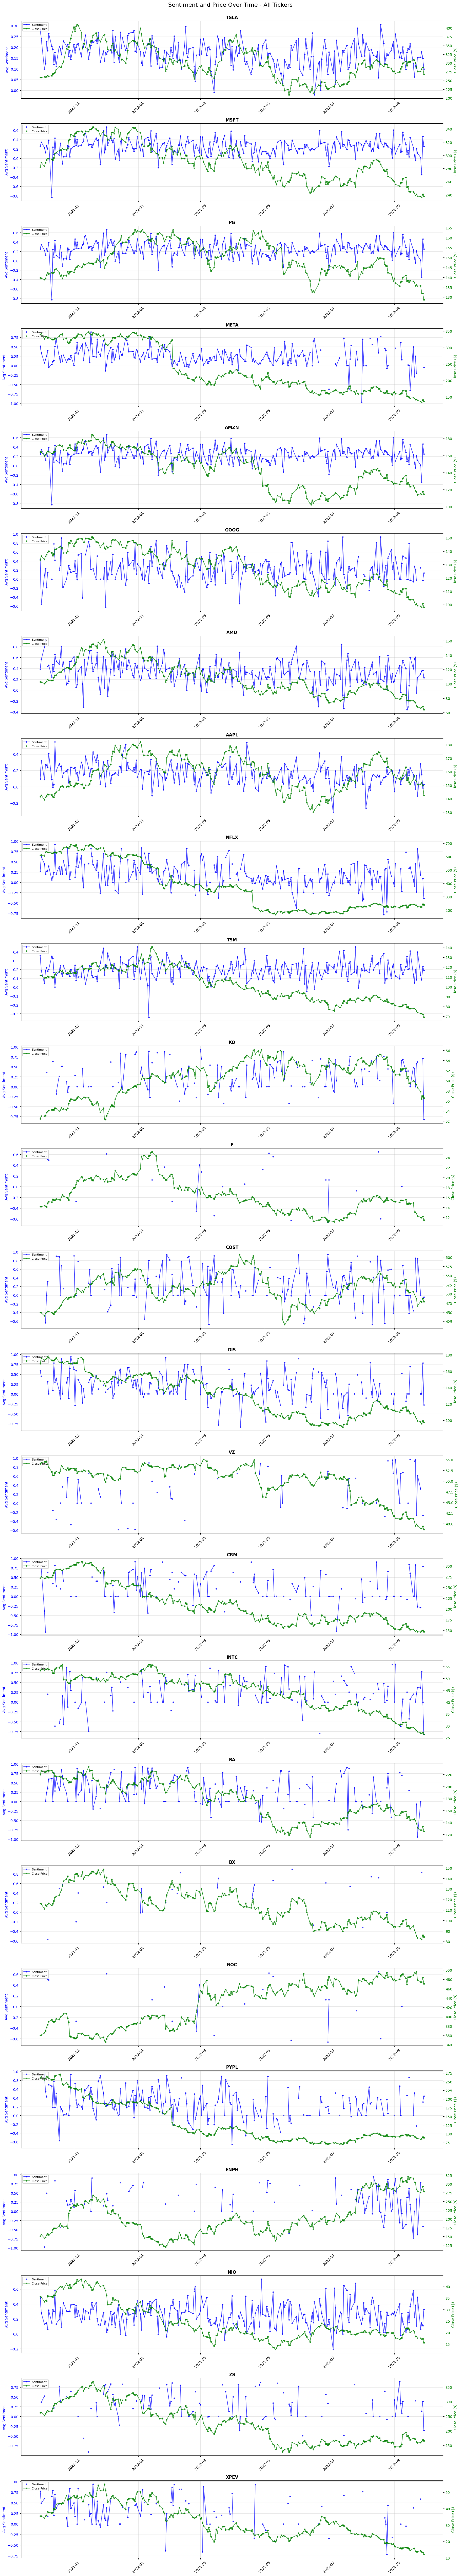

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique tickers
tickers = merged_df['Ticker'].unique()
num_tickers = len(tickers)

# Calculate grid dimensions (rows x columns)
cols = 1  # 3 columns
rows = int(np.ceil(num_tickers / cols))

# Create figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
fig.suptitle('Sentiment and Price Over Time - All Tickers', fontsize=16, y=1.00)

# Flatten axes array for easier iteration
axes = axes.flatten() if num_tickers > 1 else [axes]

# Plot each ticker
for idx, ticker in enumerate(tickers):
    ticker_data = merged_df[merged_df['Ticker'] == ticker].sort_values('date_only')

    ax = axes[idx]

    # Create twin axis for price
    ax2 = ax.twinx()

    # Plot sentiment on left axis
    line1 = ax.plot(ticker_data['date_only'], ticker_data['avg_sentiment'],
                     marker='o', color='blue', alpha=0.7, label='Sentiment', markersize=3)
    ax.set_ylabel('Avg Sentiment', color='blue', fontsize=10)
    ax.tick_params(axis='y', labelcolor='blue')

    # Plot price on right axis
    line2 = ax2.plot(ticker_data['date_only'], ticker_data['Close'],
                      marker='s', color='green', alpha=0.7, label='Close Price', markersize=3)
    ax2.set_ylabel('Close Price ($)', color='green', fontsize=10)
    ax2.tick_params(axis='y', labelcolor='green')

    # Set title and format
    ax.set_title(f'{ticker}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left', fontsize=8)

# Hide empty subplots
for idx in range(num_tickers, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()


## Step 6: Individual Sentiment and Price Trends

This code generates individual plots for each unique stock ticker, displaying the average sentiment and closing price over time.

-   **Process:**
    -   It iterates through each unique stock ticker in the `merged_df`.
    -   For each ticker, it creates a figure with two subplots: one for `avg_sentiment` and another for `Close` price, both sharing the same x-axis (date).
    -   Each subplot includes a title with the ticker name, appropriate axis labels, and a legend.
-   **Outcome:** Separate visualizations for each stock, allowing for focused analysis of sentiment and price movements for individual companies.

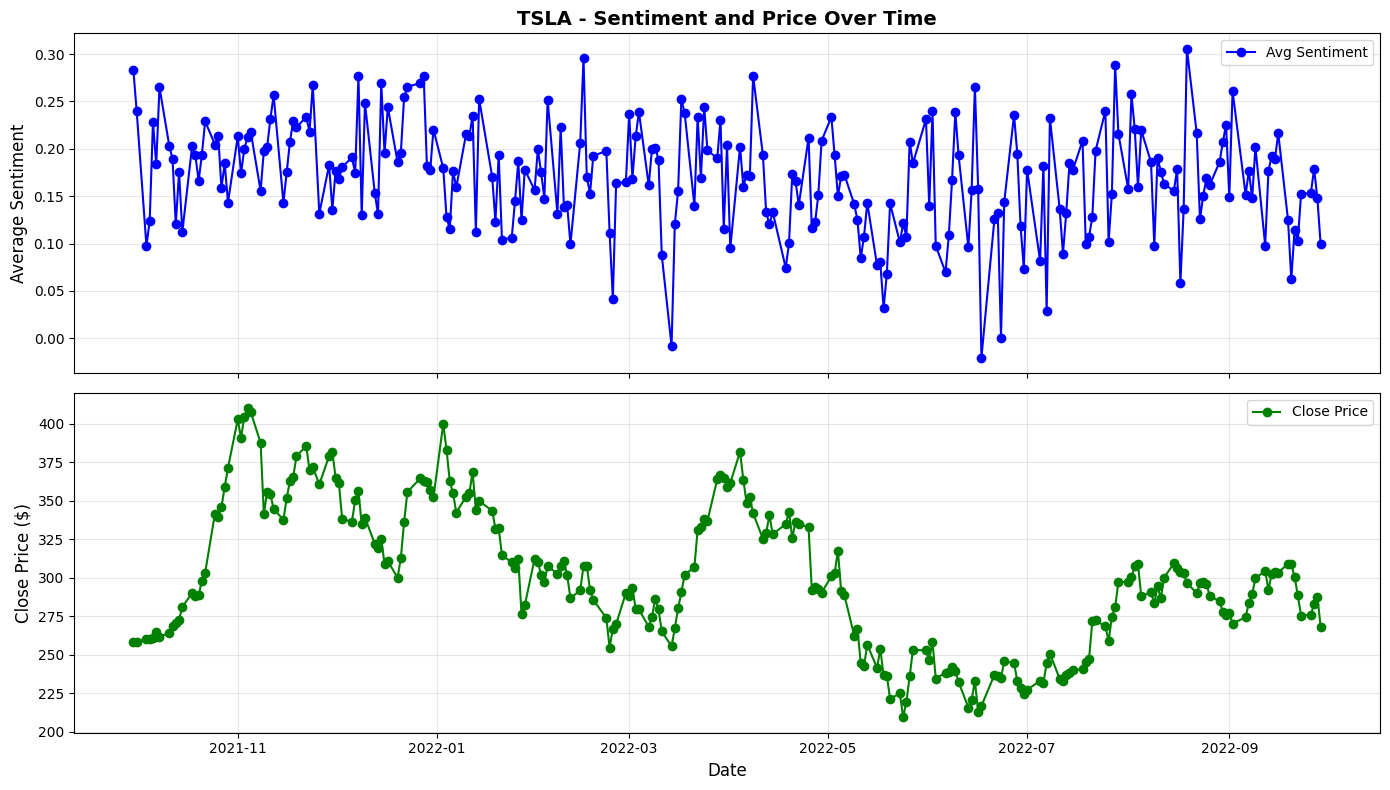

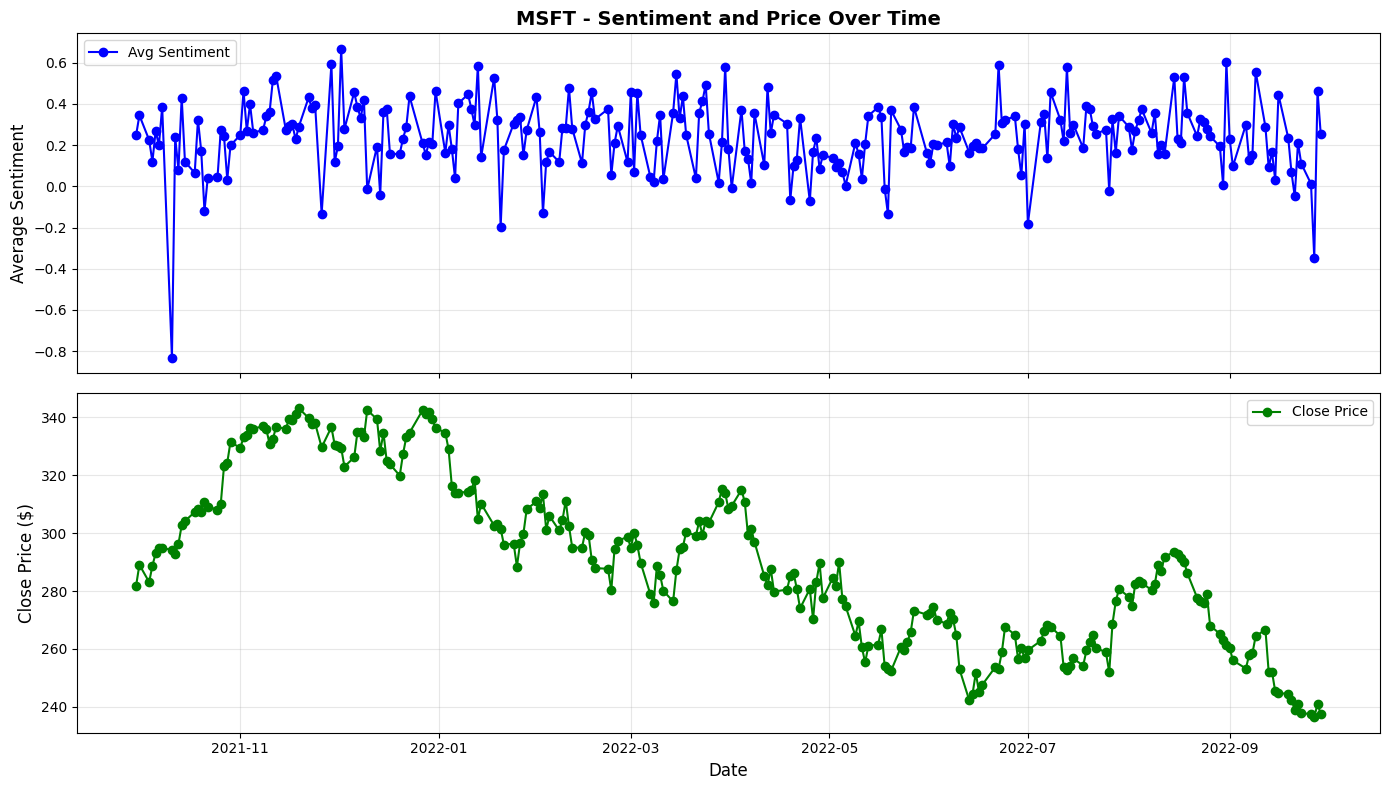

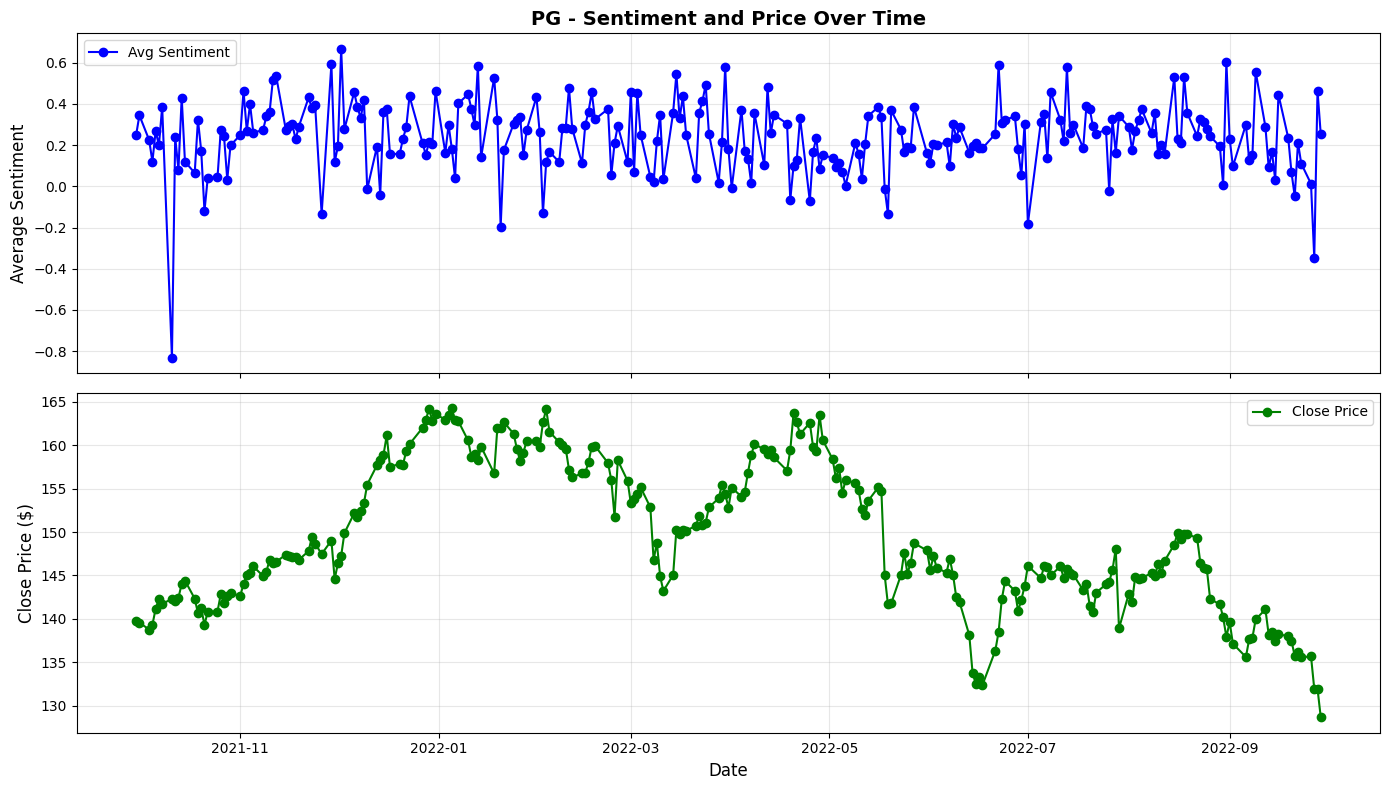

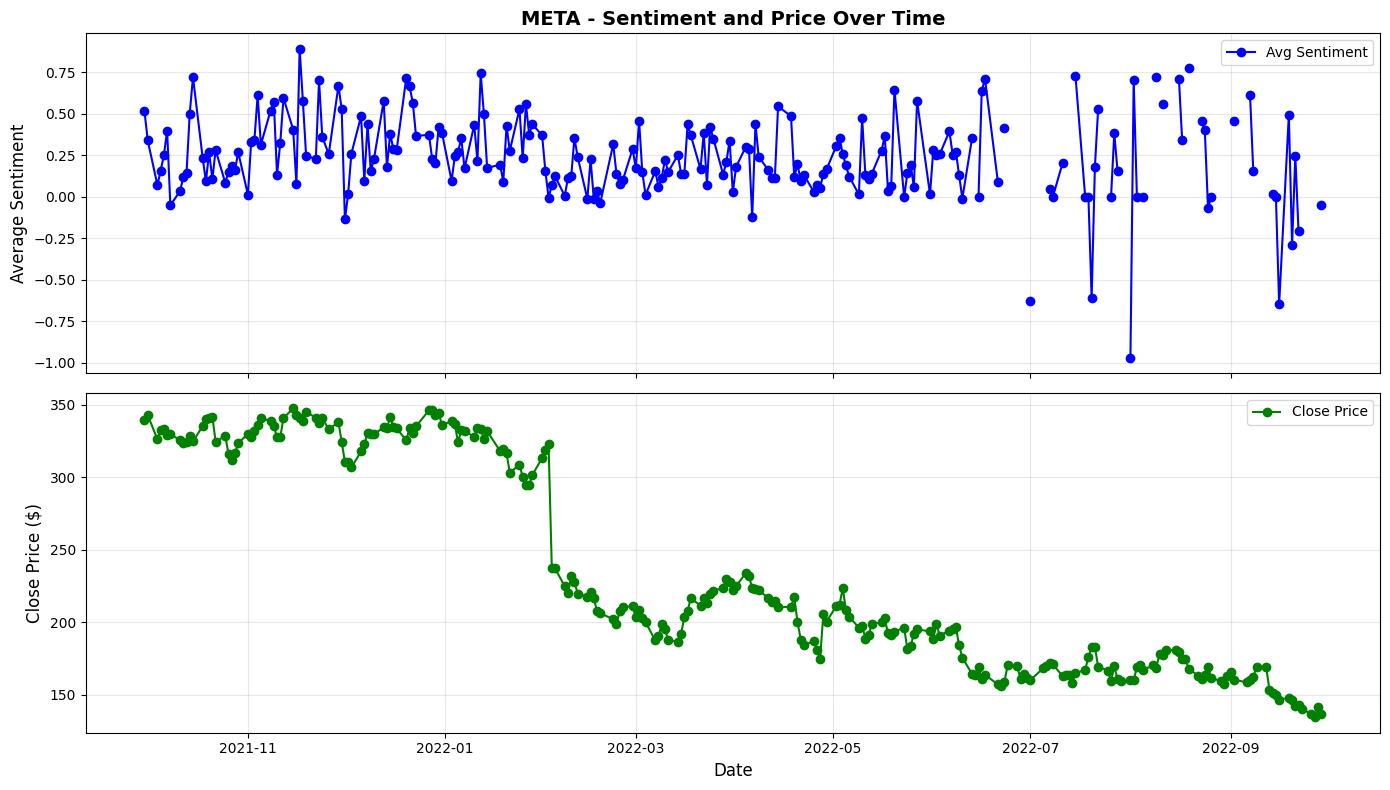

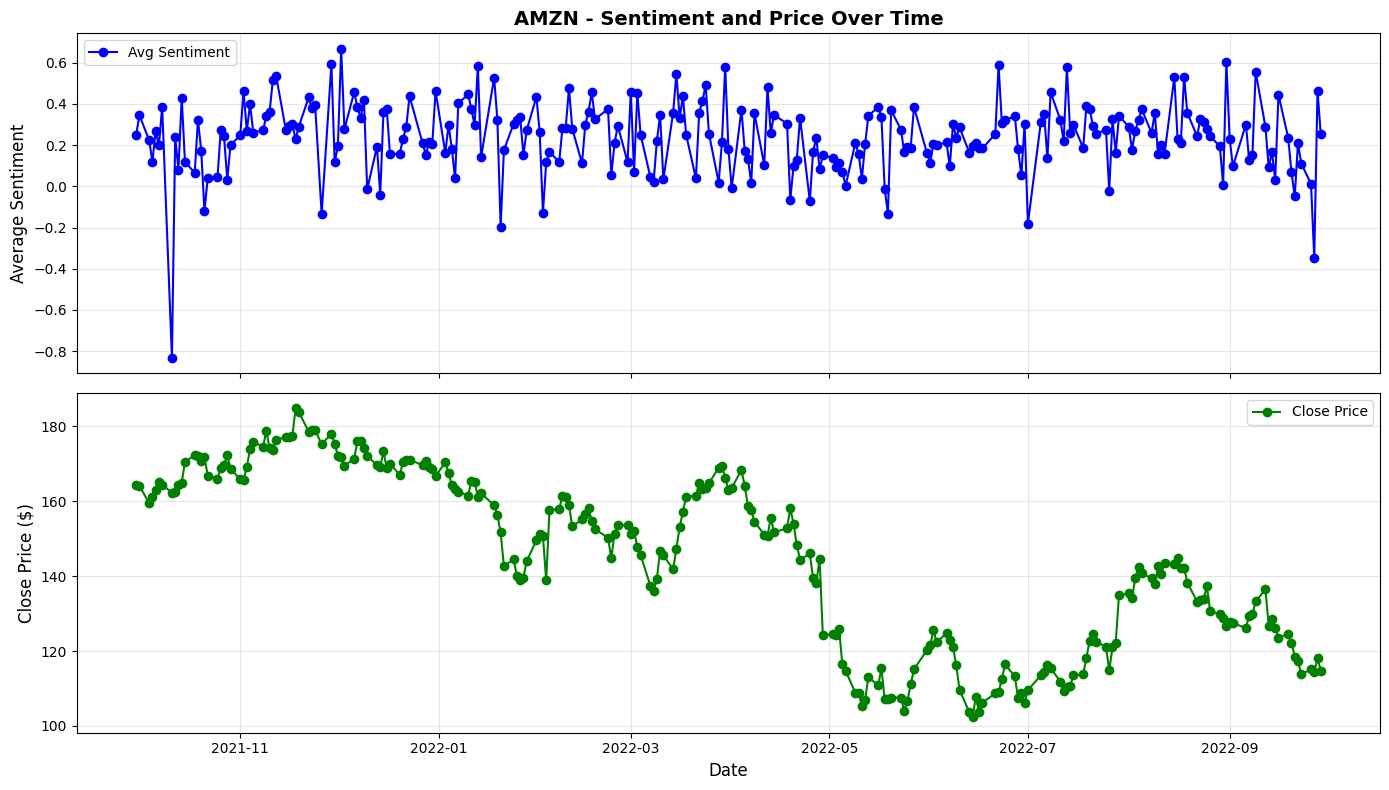

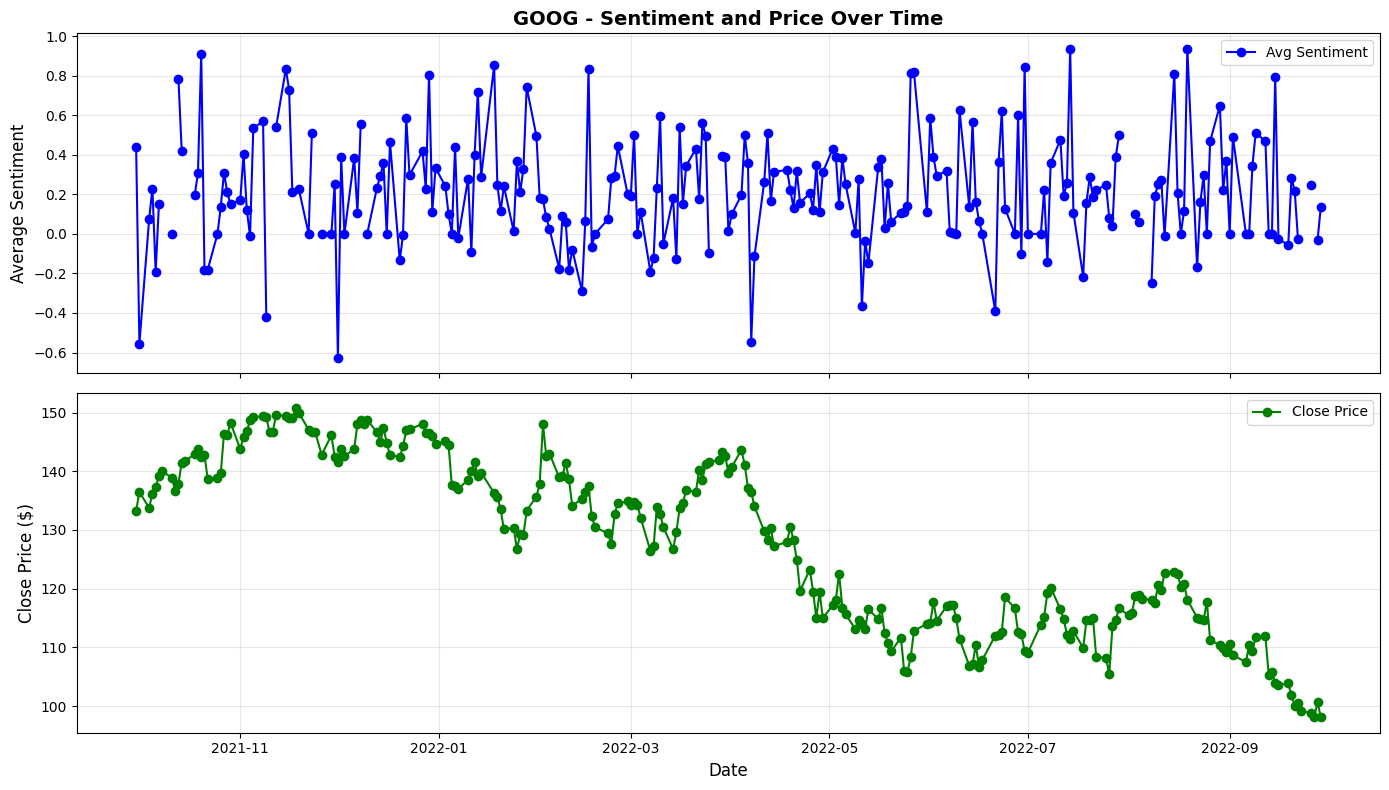

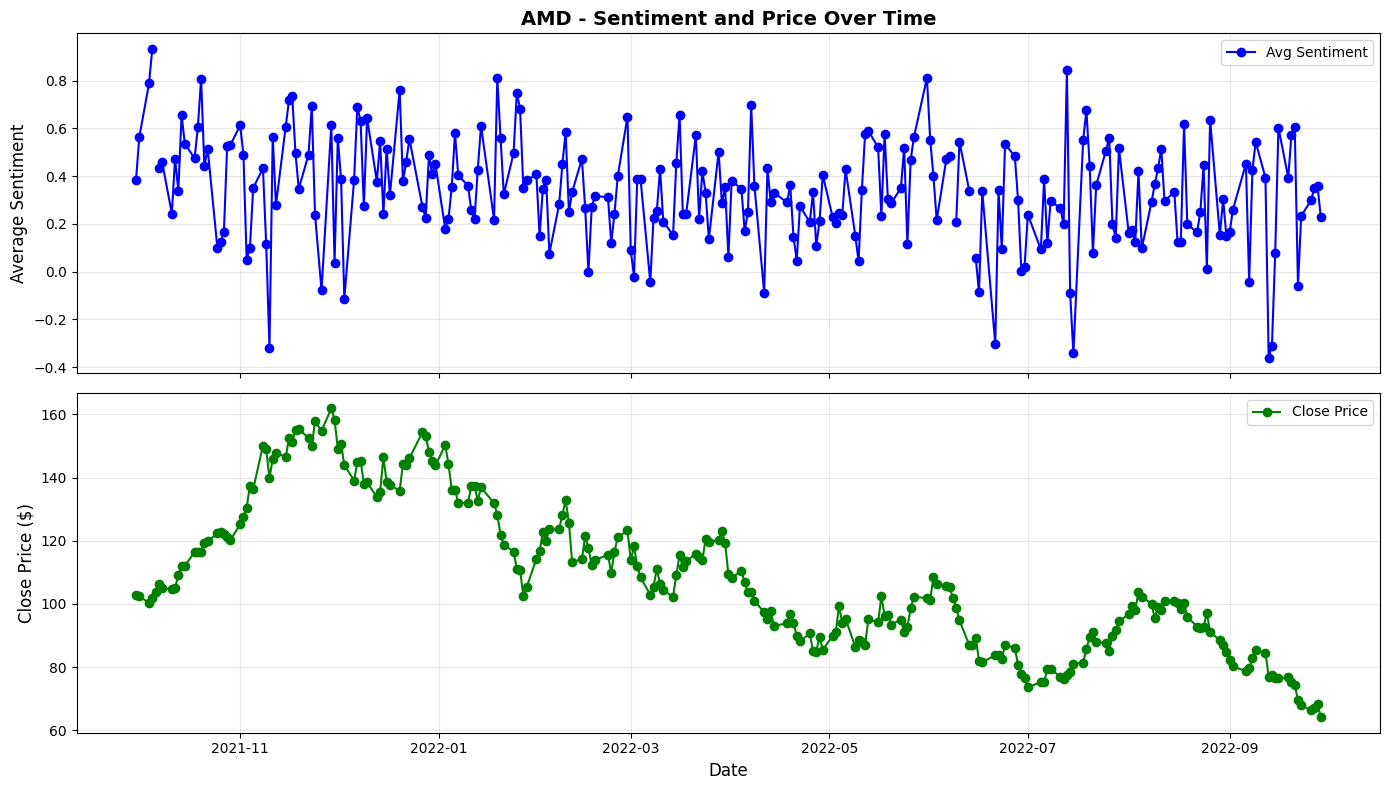

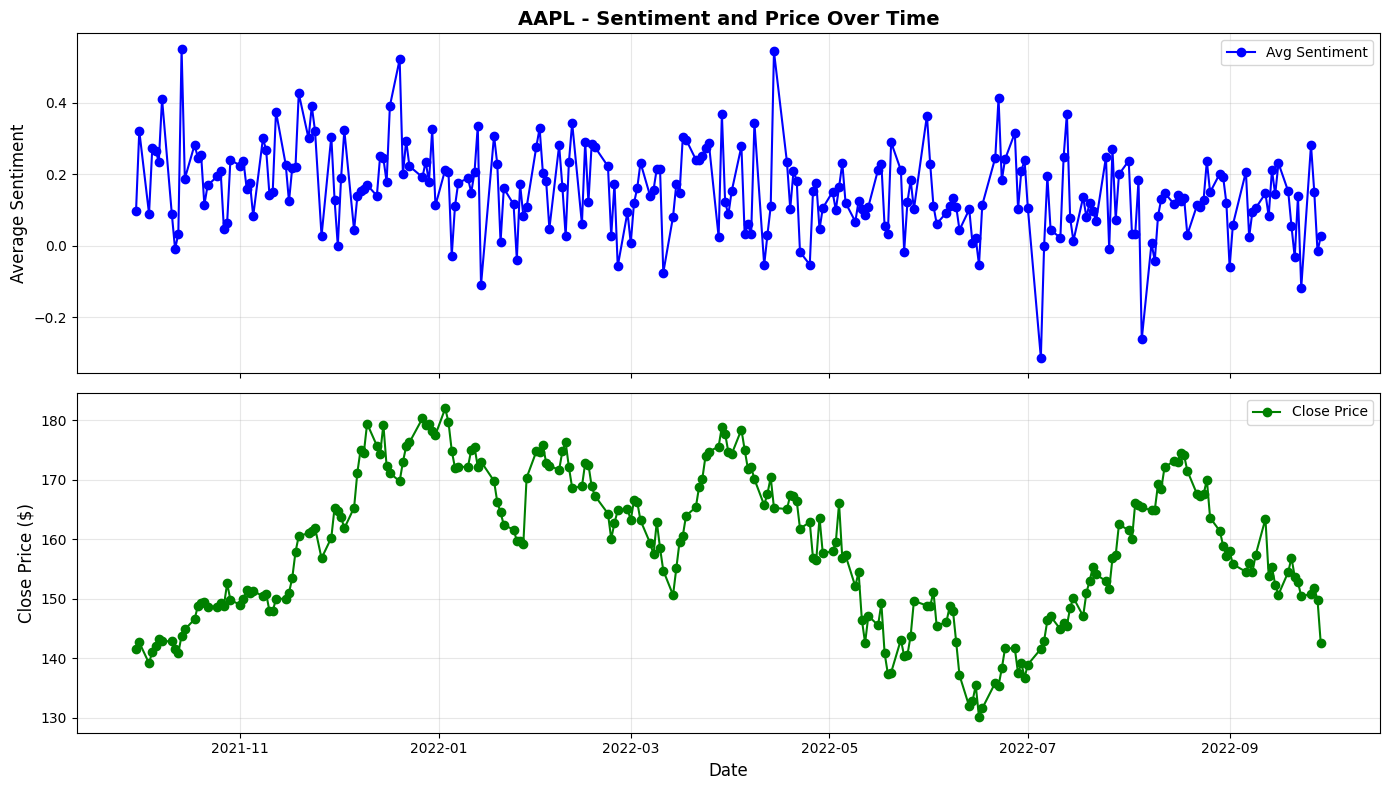

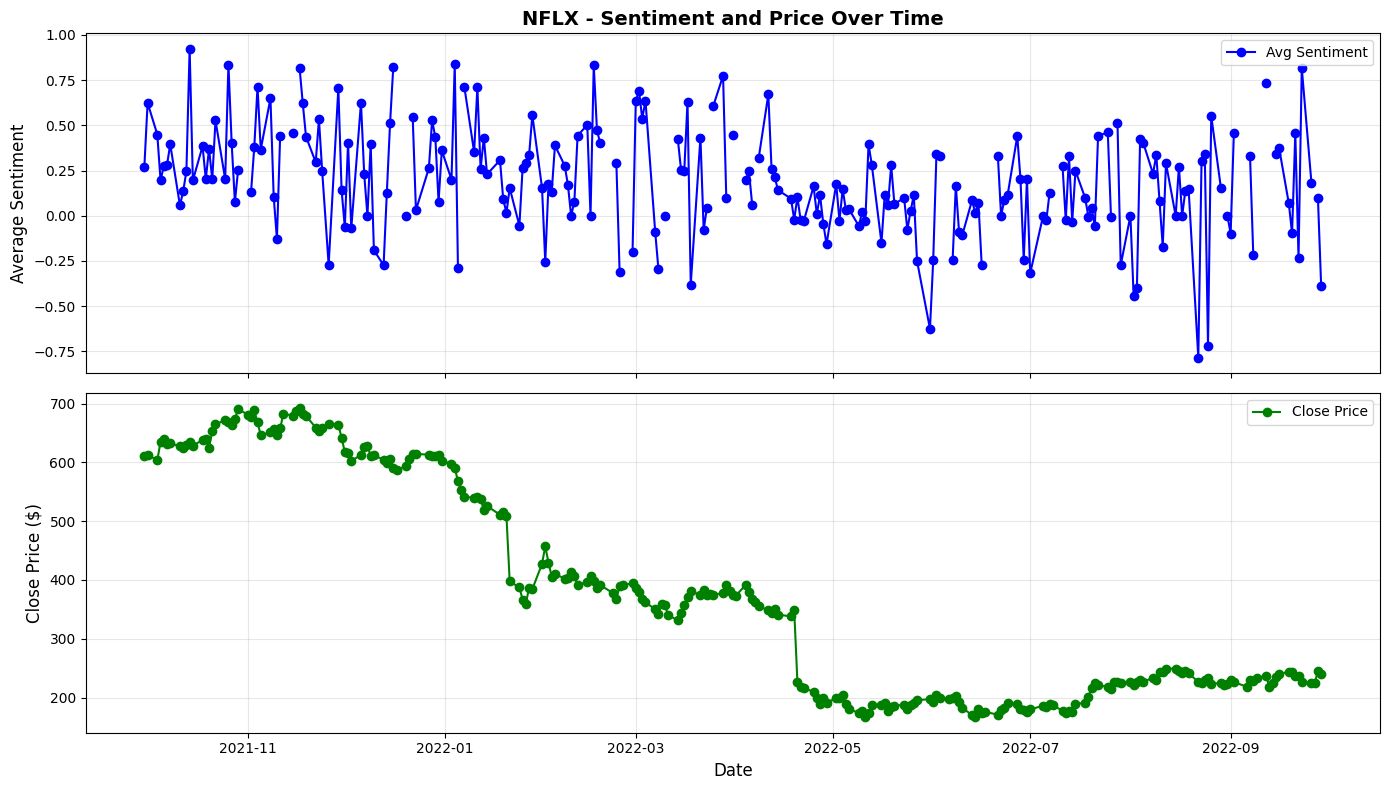

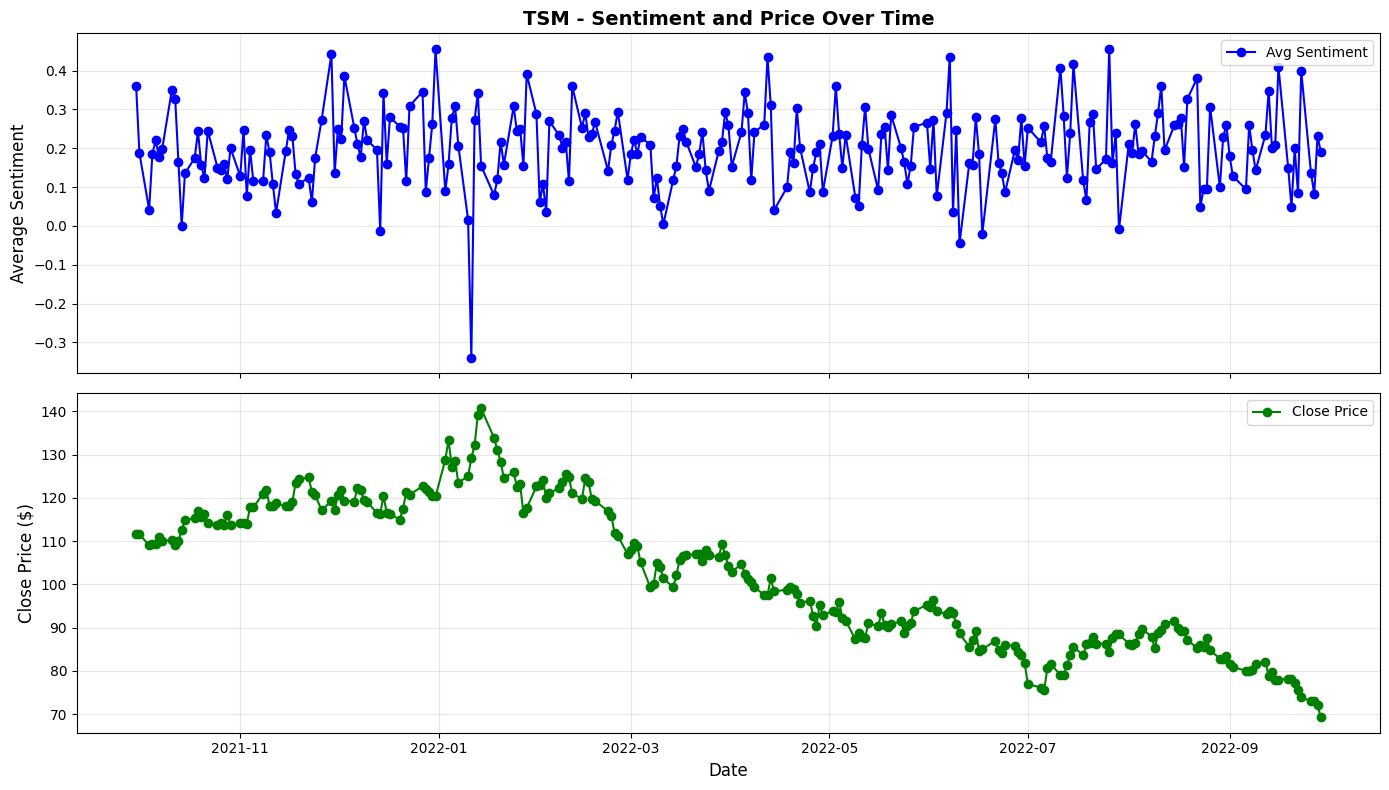

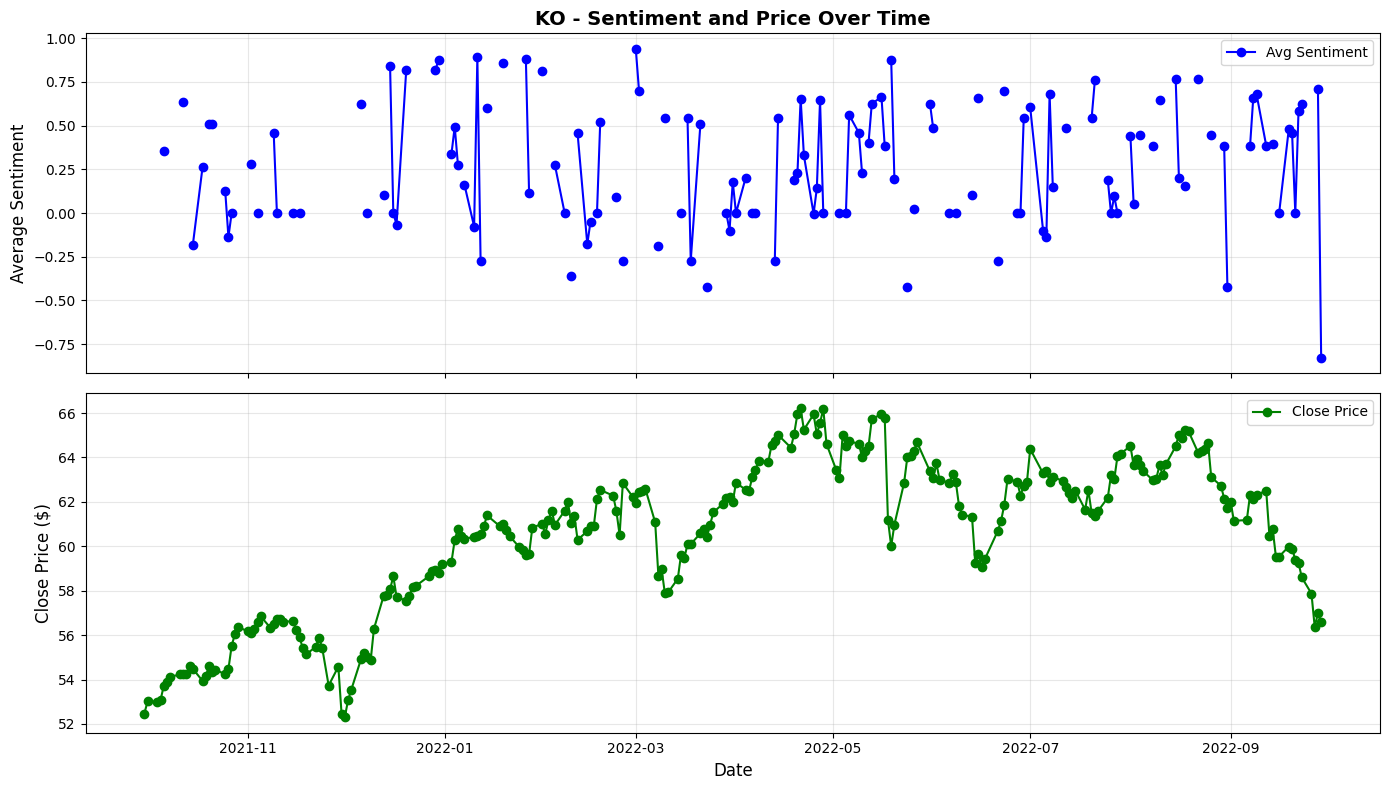

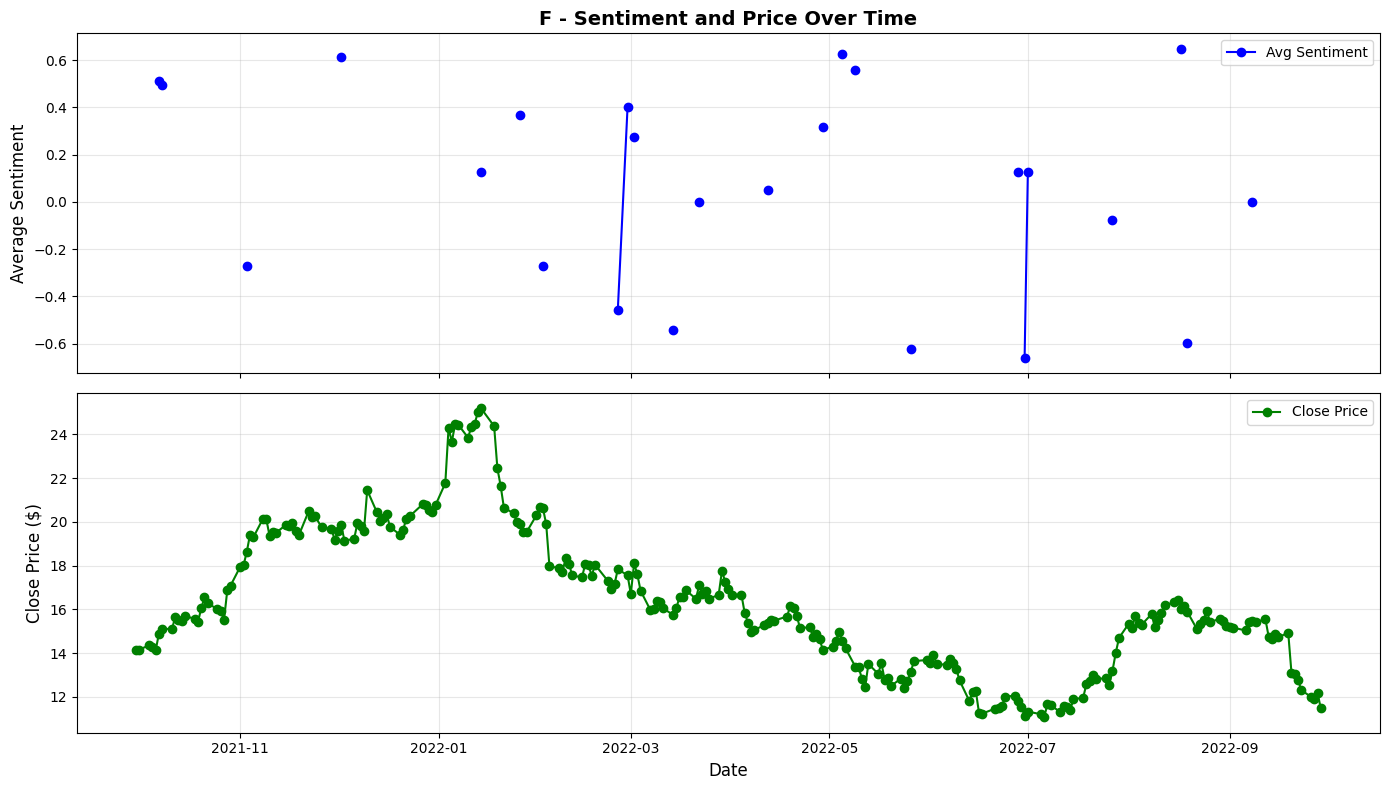

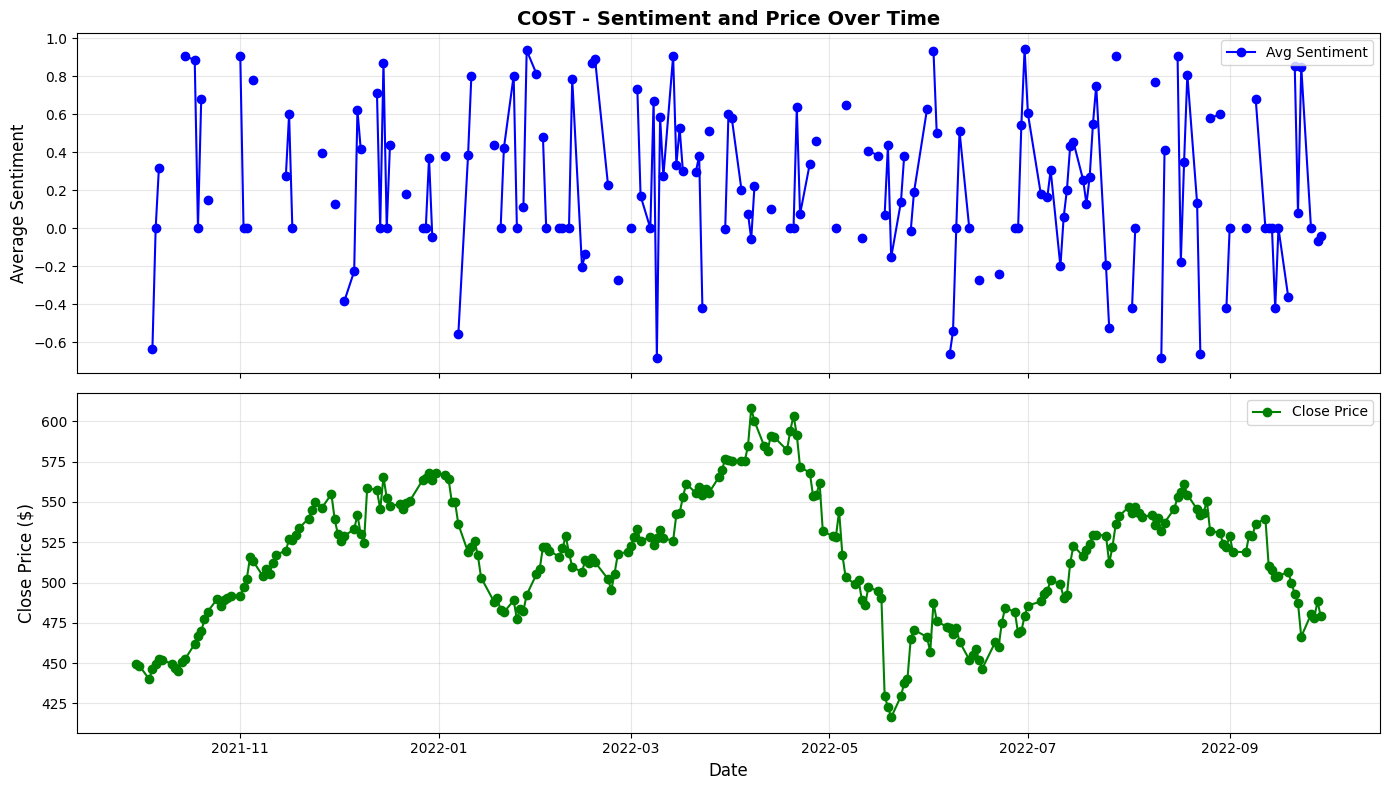

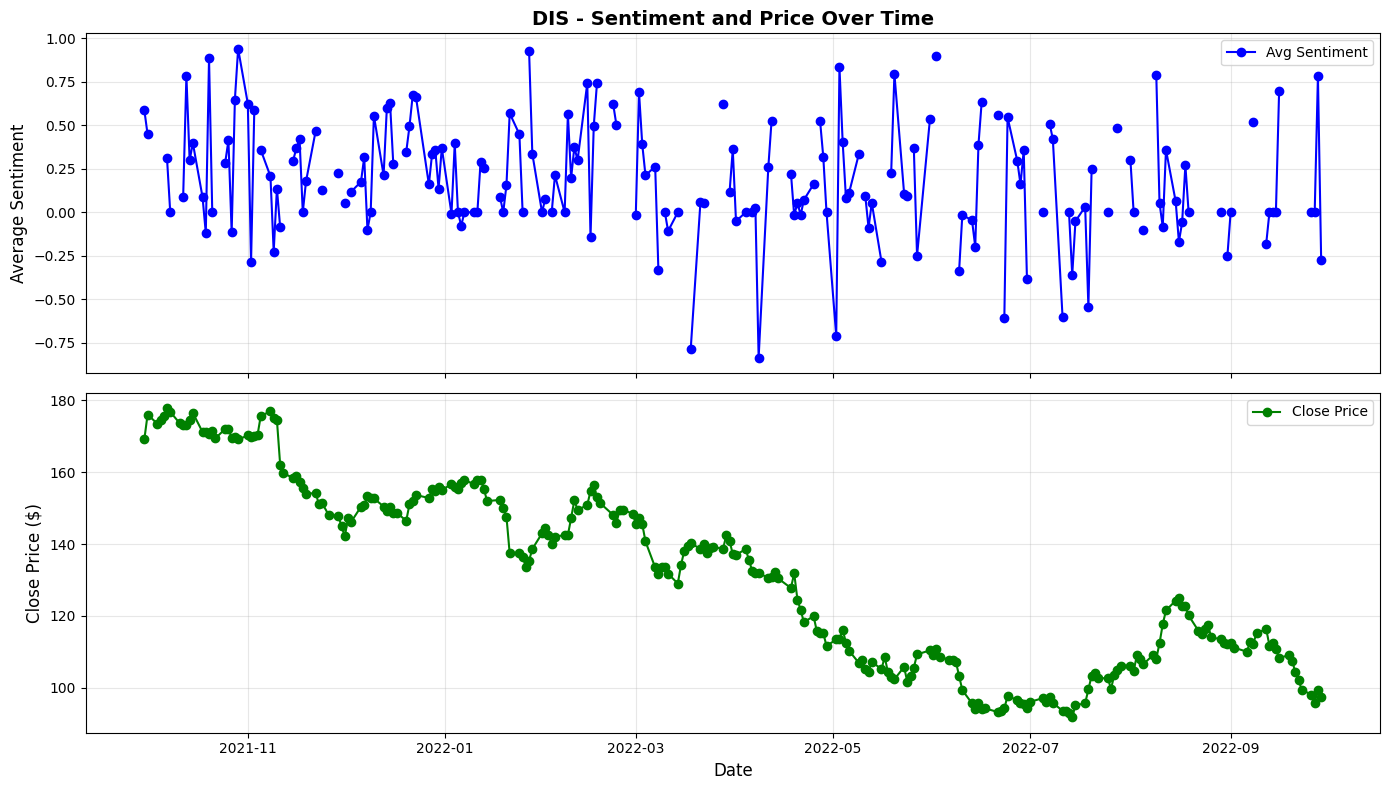

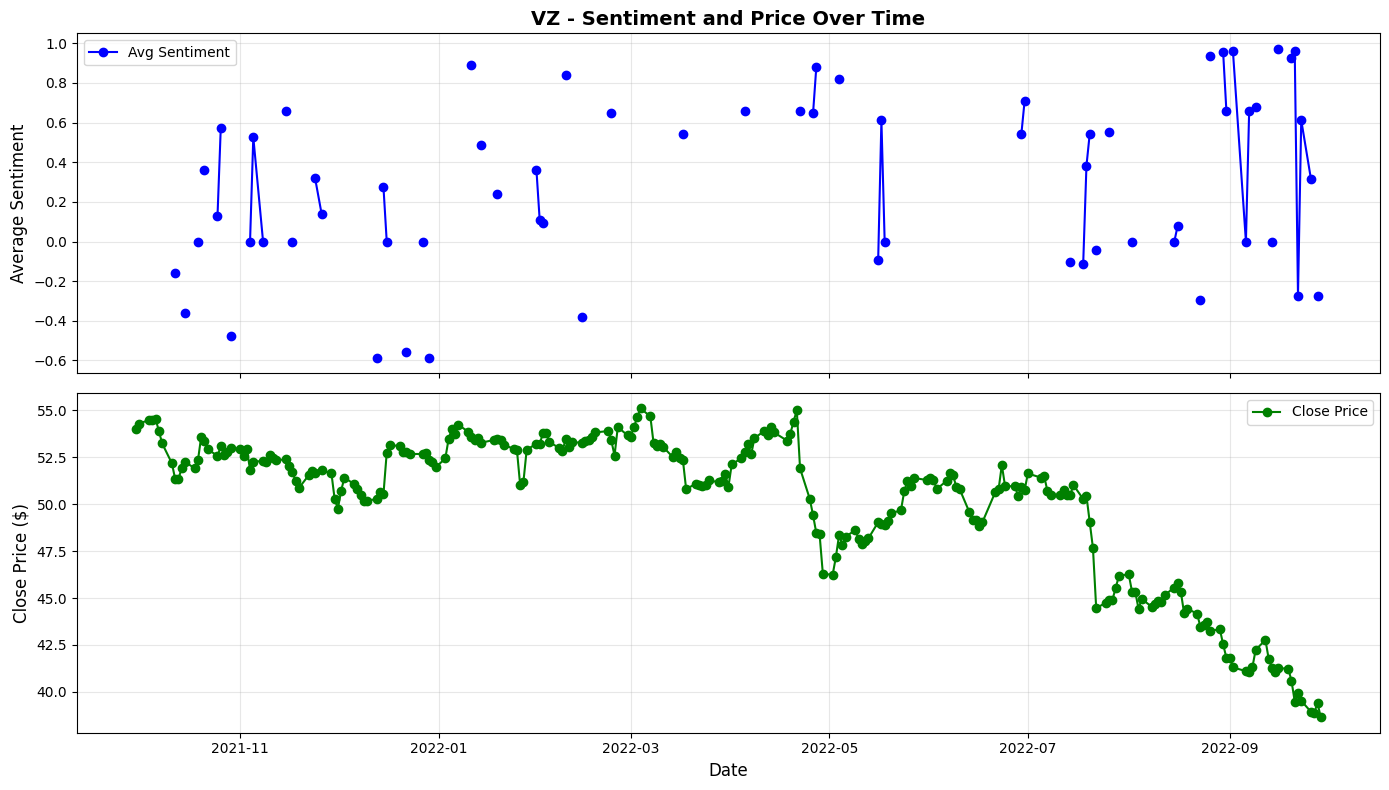

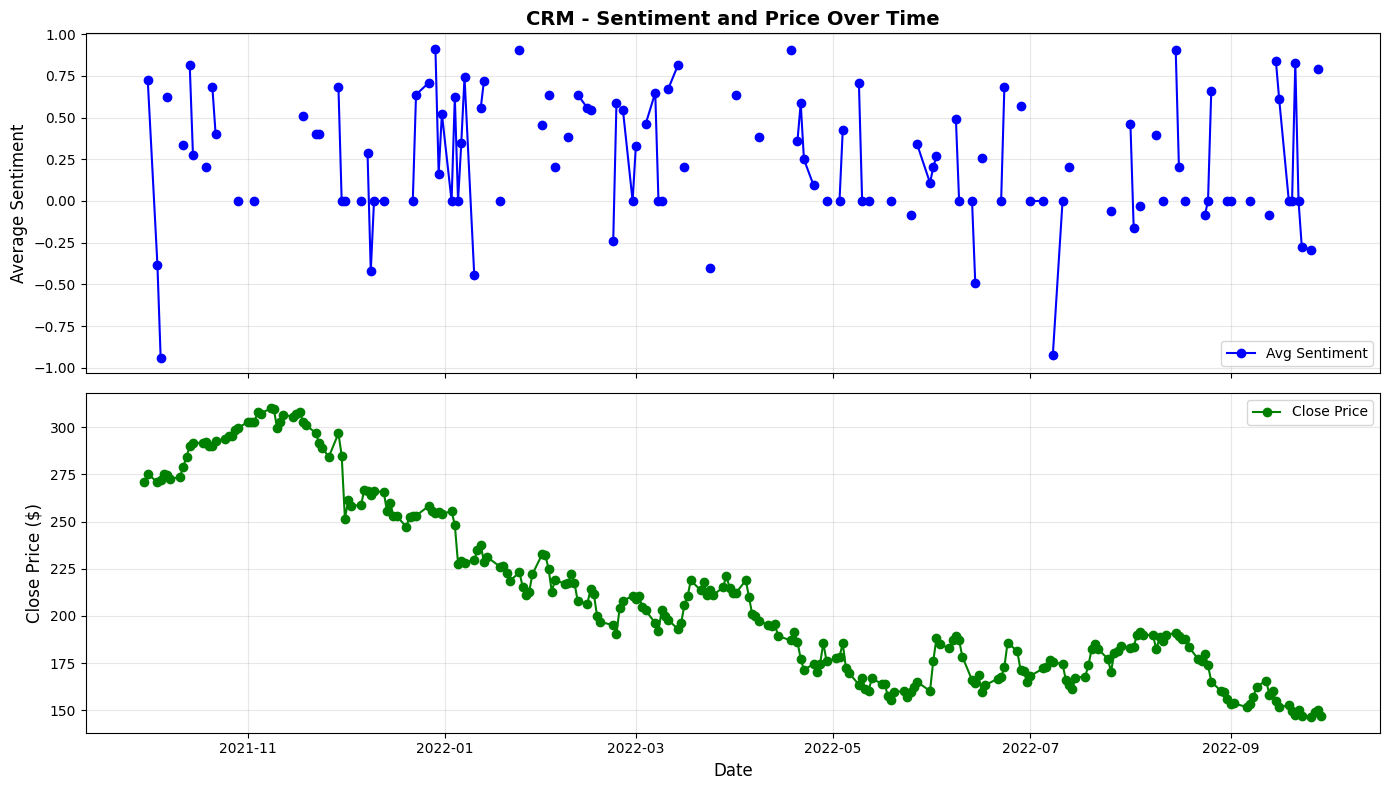

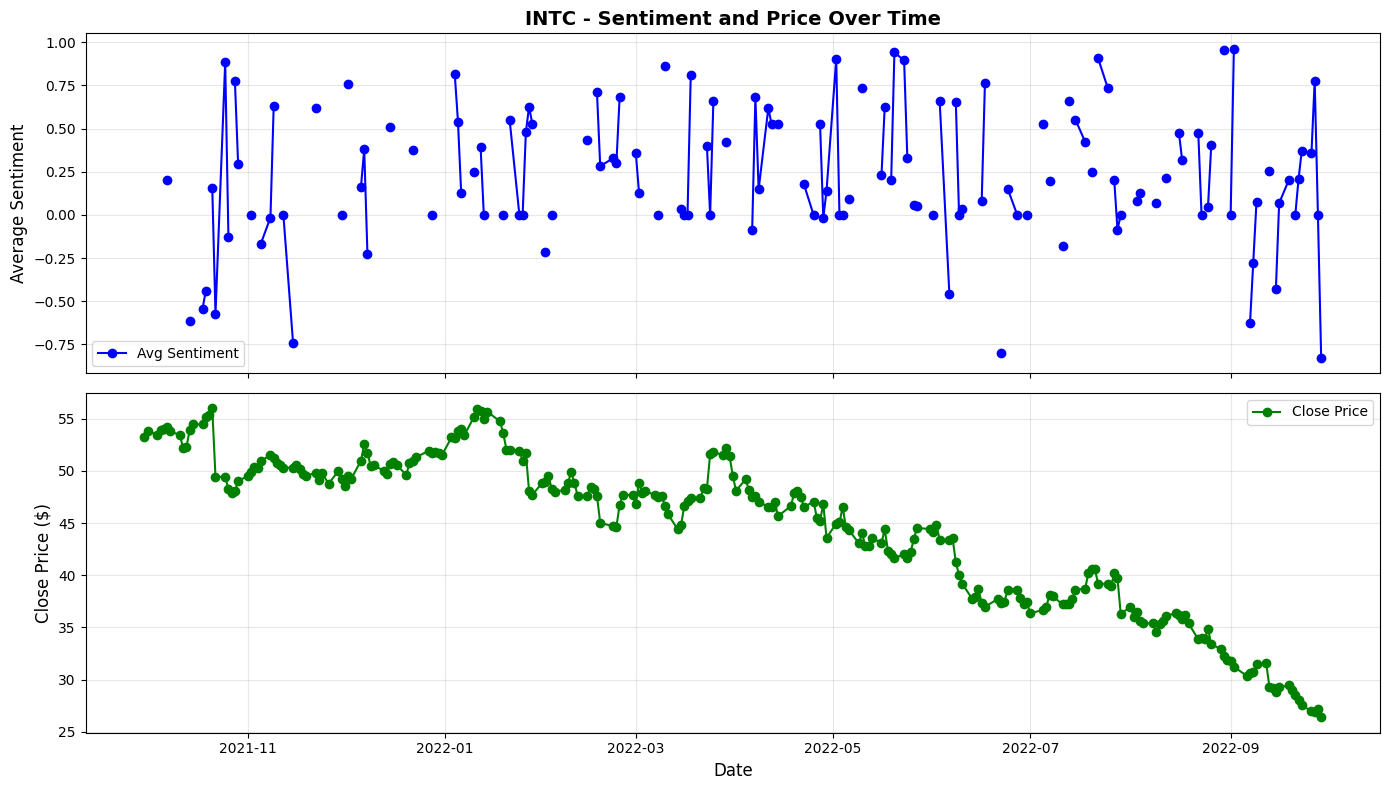

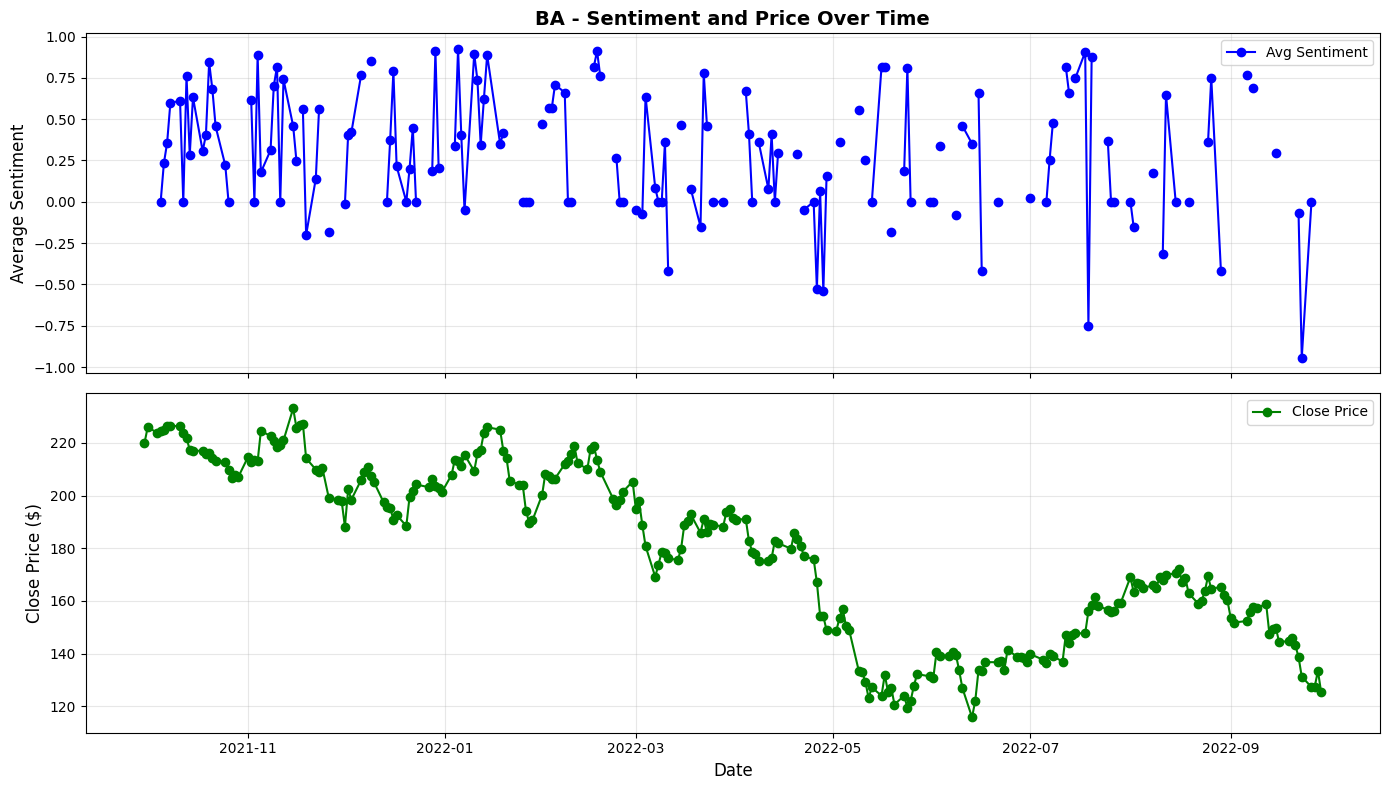

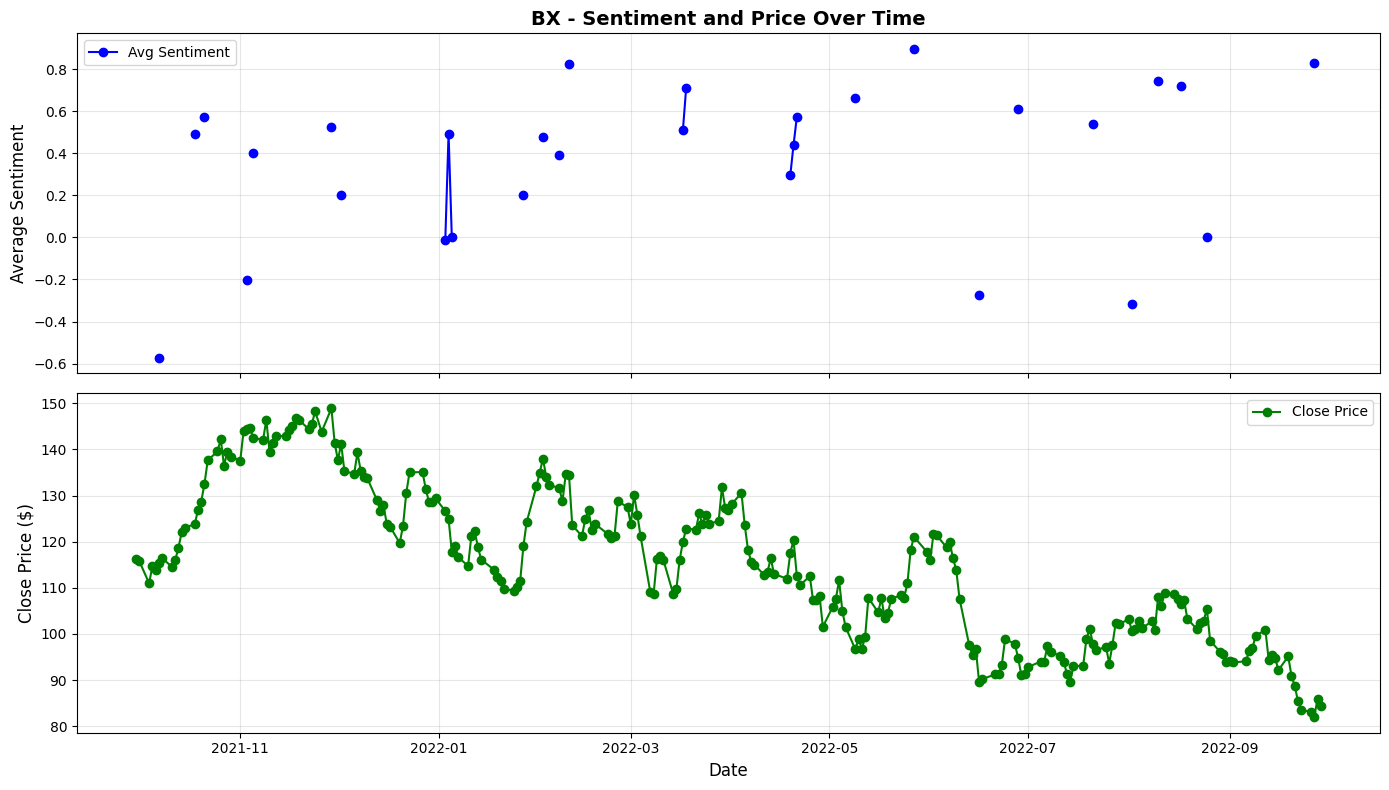

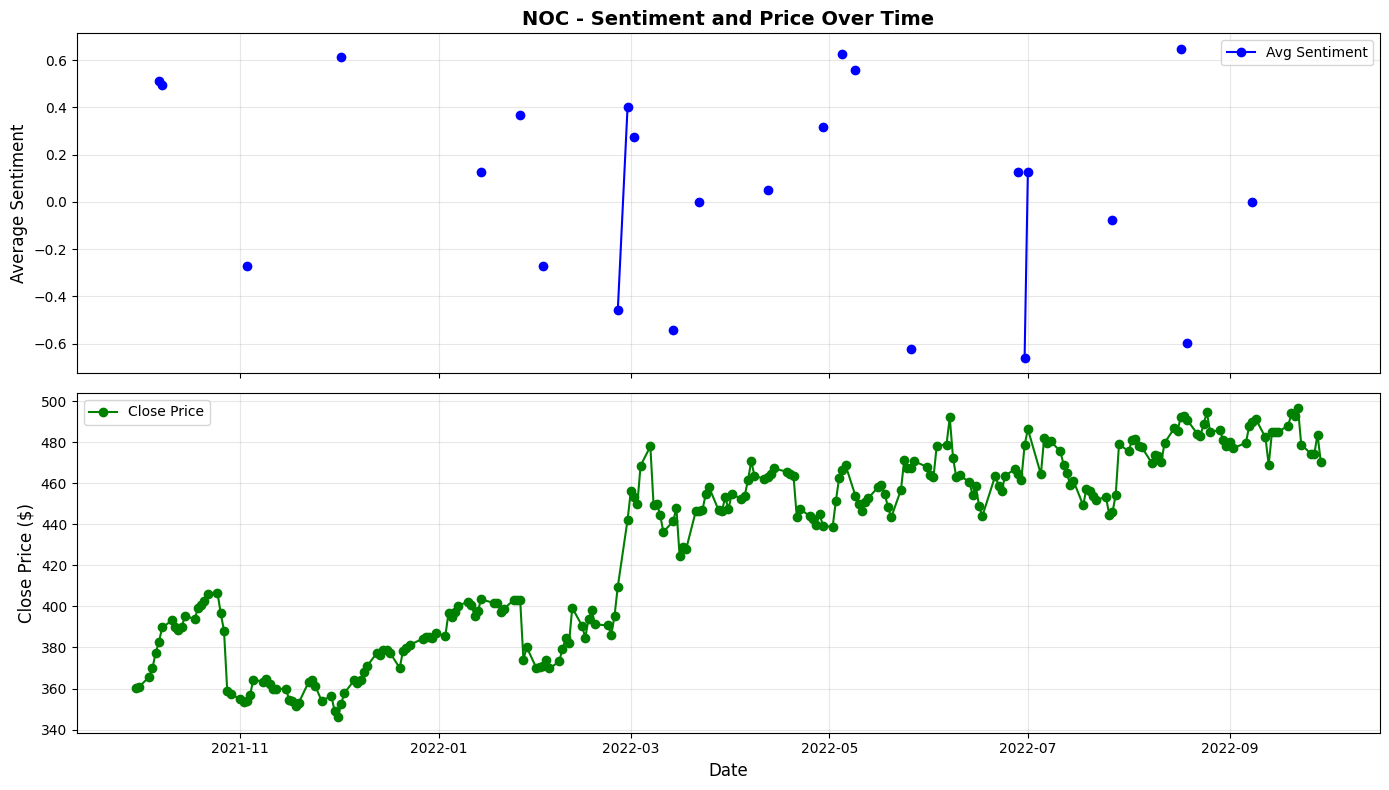

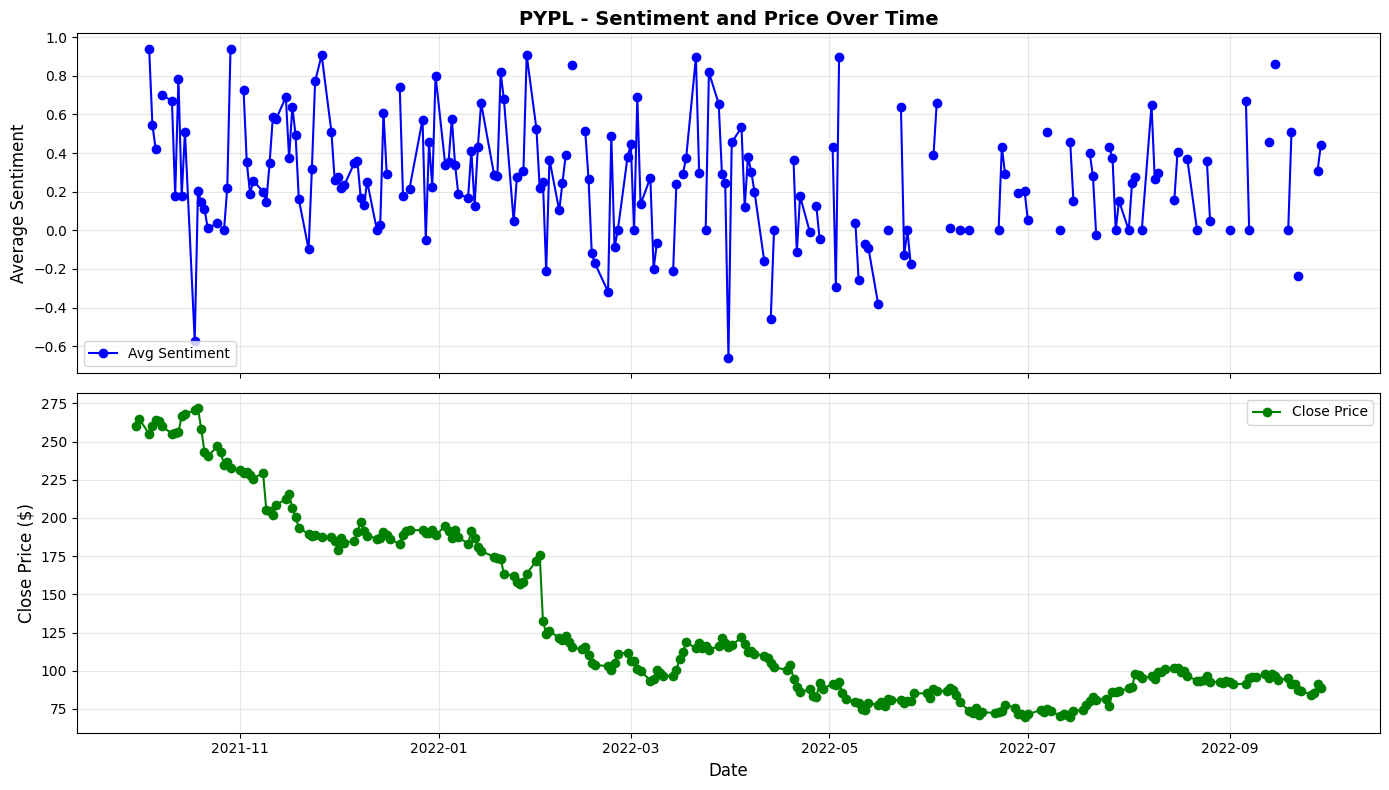

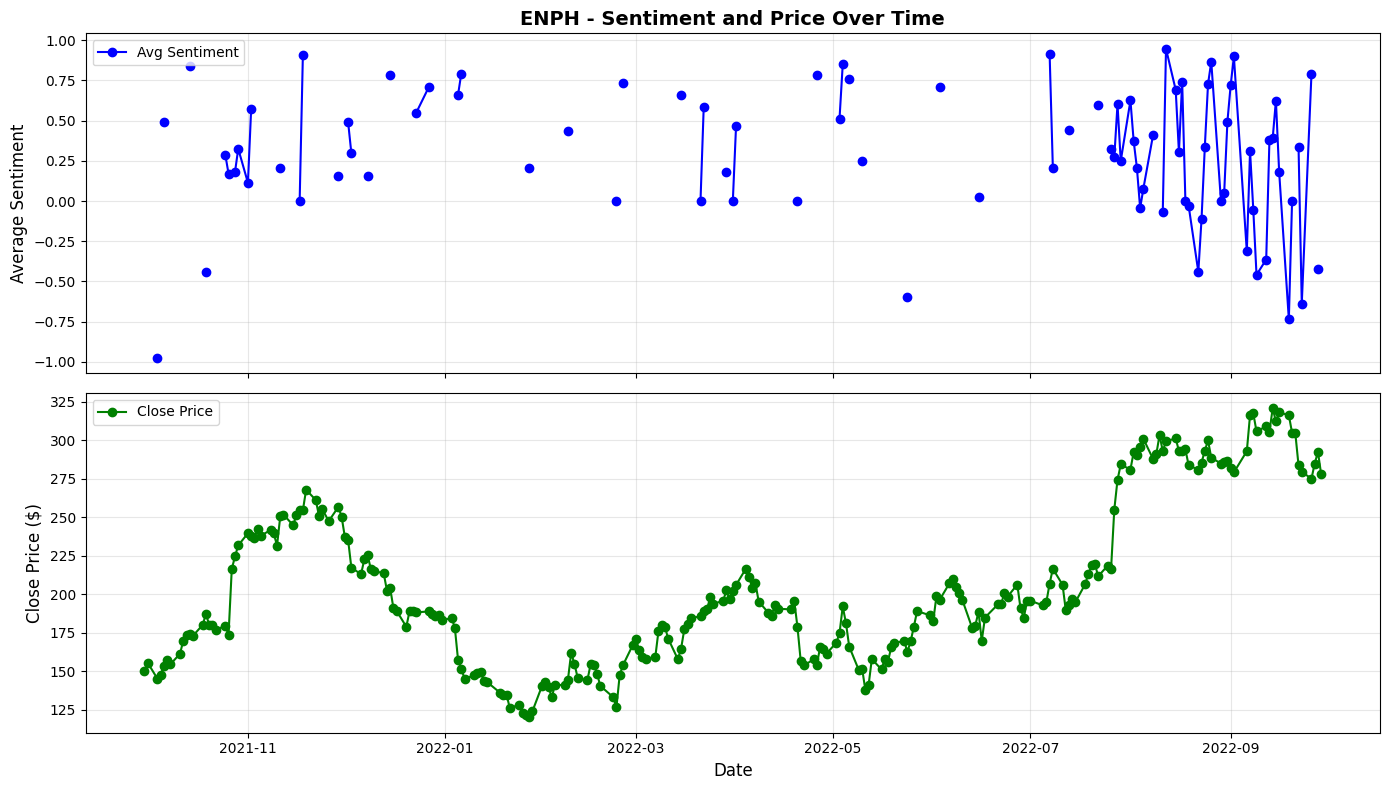

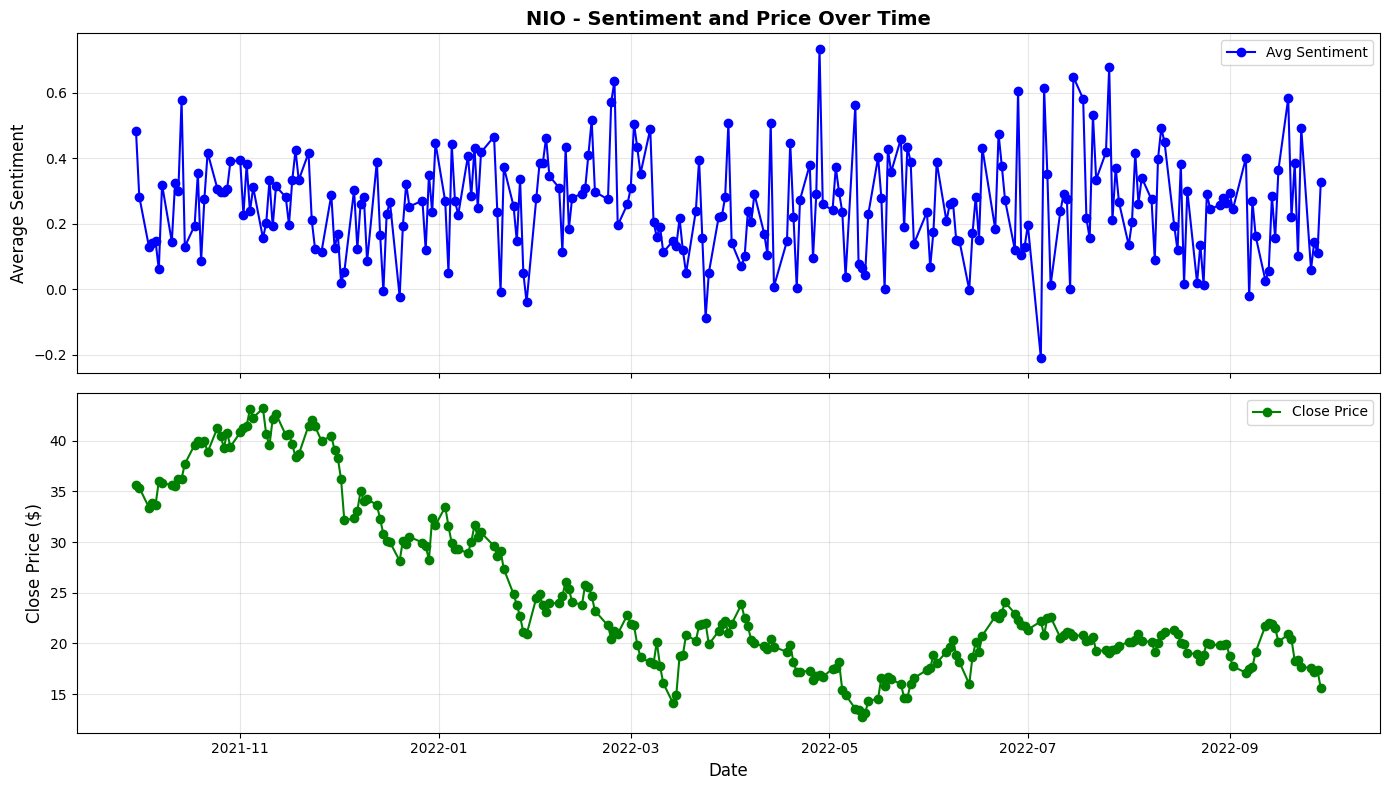

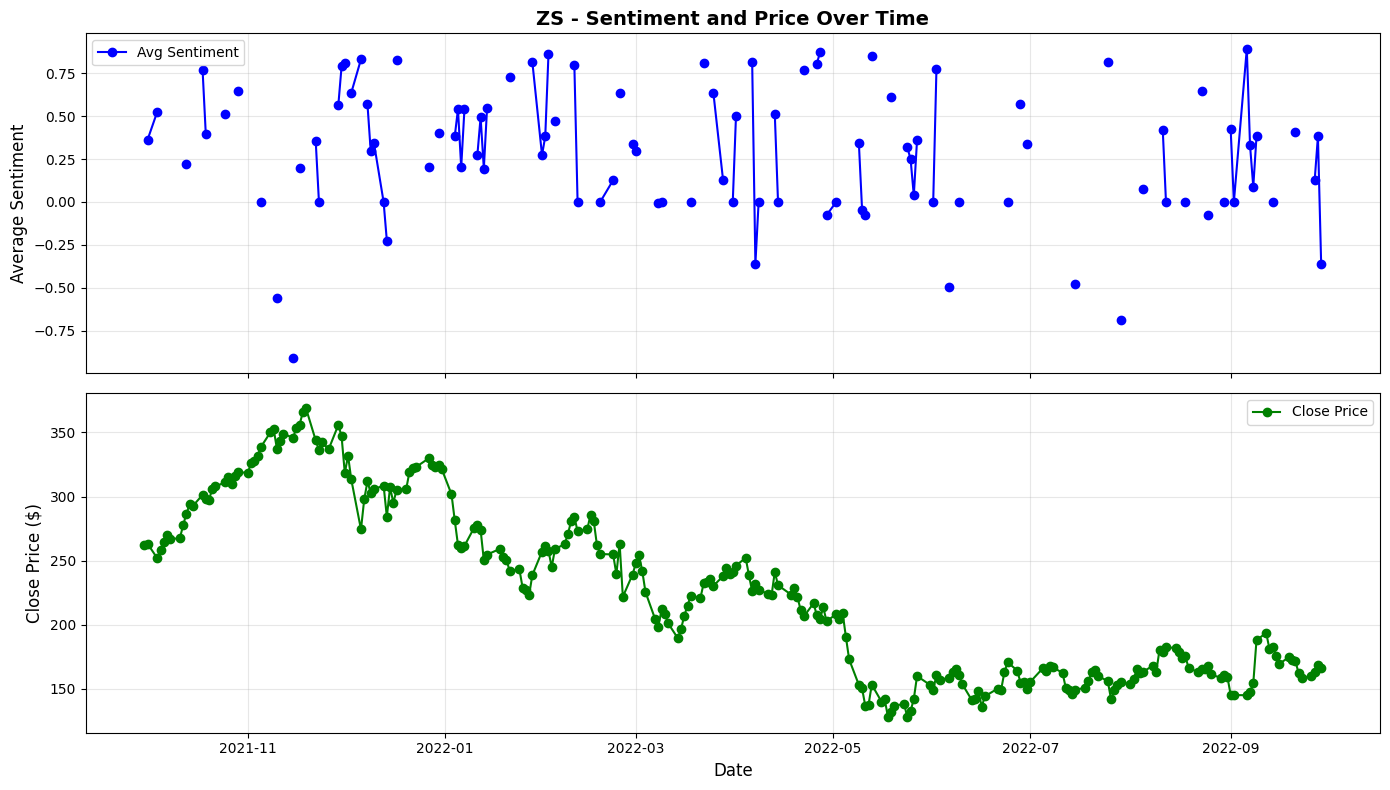

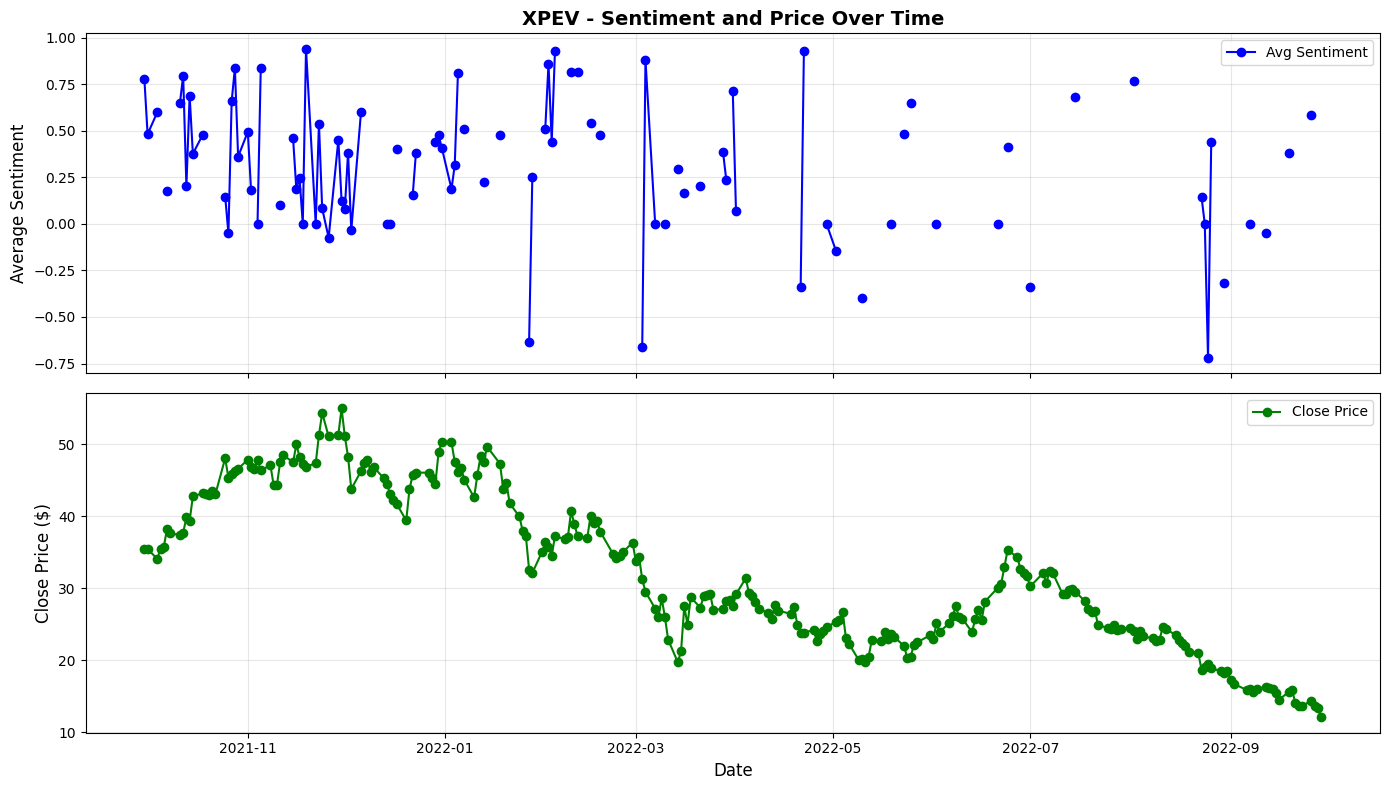

In [ ]:
import matplotlib.pyplot as plt

# Get unique tickers
tickers = merged_df['Ticker'].unique()

# Plot each ticker individually
for ticker in tickers:
    ticker_data = merged_df[merged_df['Ticker'] == ticker].sort_values('date_only')

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Plot sentiment
    ax1.plot(ticker_data['date_only'], ticker_data['avg_sentiment'],
             marker='o', color='blue', label='Avg Sentiment')
    ax1.set_ylabel('Average Sentiment', fontsize=12)
    ax1.set_title(f'{ticker} - Sentiment and Price Over Time', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Plot closing price
    ax2.plot(ticker_data['date_only'], ticker_data['Close'],
             marker='o', color='green', label='Close Price')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Close Price ($)', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()


**Calculate Sentiment-Price Correlation**

## Step 7: Correlation Check
We perform a sanity check to see if our new sentiment feature has any linear relationship with stock prices.
- **Process:** For each unique stock, we calculate the Pearson correlation between `avg_sentiment` and `Close` price.
- **Outcome:** A list of stocks sorted by how strongly their price correlates with sentiment.

In [ ]:
# Calculate correlation between sentiment and price for each ticker
correlations = []

for ticker in merged_df['Ticker'].unique():
    ticker_subset = merged_df[merged_df['Ticker'] == ticker][['avg_sentiment', 'Close']].dropna()

    if len(ticker_subset) > 1:
        corr = ticker_subset['avg_sentiment'].corr(ticker_subset['Close'])
        correlations.append({'Ticker': ticker, 'Correlation': corr})

corr_df = pd.DataFrame(correlations).sort_values('Correlation', ascending=False)
display(corr_df)


Ticker  Correlation
8    NFLX     0.355931
0    TSLA     0.330590
3    META     0.276217
20   PYPL     0.264155
17     BA     0.244603
13    DIS     0.212889
6     AMD     0.207706
24   XPEV     0.198059
1    MSFT     0.152573
23     ZS     0.128447
15    CRM     0.121554
4    AMZN     0.120078
11      F     0.108837
7    AAPL     0.103620
2      PG     0.049183
10     KO     0.040498
12   COST     0.032620
22    NIO     0.030363
16   INTC     0.026245
5    GOOG     0.024782
18     BX    -0.011108
9     TSM    -0.029105
21   ENPH    -0.148365
19    NOC    -0.152389
14     VZ    -0.223355

## Step 8: Save Dataset
Finally, we save the processed, merged dataset to a CSV file.
- **File:** `merged_sentiment_price_data.csv`
- **Usage:** This file is the input for all subsequent Machine Learning and Deep Learning models.

In [ ]:
# Save the merged dataset for later use in deep learning models
merged_df.to_csv('merged_sentiment_price_data.csv', index=False)
print("Merged dataset saved as 'merged_sentiment_price_data.csv'")


Merged dataset saved as 'merged_sentiment_price_data.csv'
